# Using DB Scan to Create Hotspots

I like DBScan, as it can create irregular areas (a run down a street), as well as incorporate crime weights. I show examples with both here.

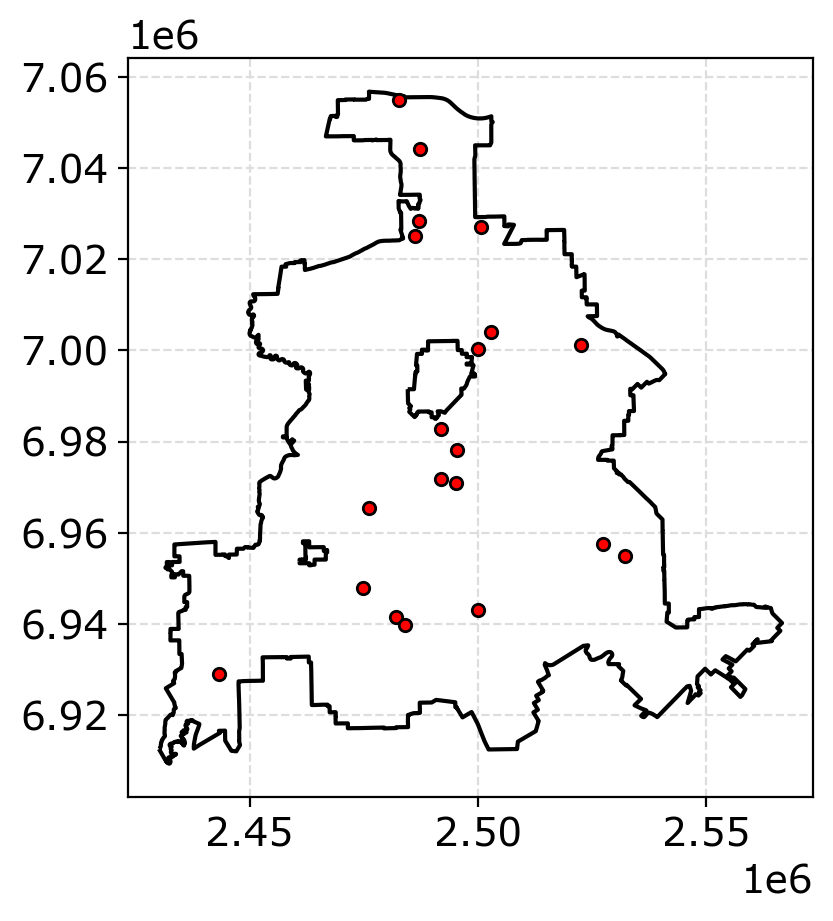

In [1]:
from crimepy import data, geo
from crimepy.cdcplot import plt
from math import ceil
import contextily as cx
import pandas as pd
import matplotlib.patches as patches

df = data.load_dallas_data()
outline = data.load_dallas_border()

# Showing the base data
ax = outline.boundary.plot(color='k')
m1 = df.sample(20).plot(marker='o', color='red', edgecolors='k', markersize=20, ax=ax, zorder=2)

In [2]:
# Note that this is projected data in feet!
# you really only want to do clustering in projected data, not lat/lon
df.crs

<Projected CRS: EPSG:2276>
Name: NAD83 / Texas North Central (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Texas - counties of: Andrews; Archer; Bailey; Baylor; Borden; Bowie; Callahan; Camp; Cass; Clay; Cochran; Collin; Cooke; Cottle; Crosby; Dallas; Dawson; Delta; Denton; Dickens; Eastland; Ellis; Erath; Fannin; Fisher; Floyd; Foard; Franklin; Gaines; Garza; Grayson; Gregg; Hale; Hardeman; Harrison; Haskell; Henderson; Hill; Hockley; Hood; Hopkins; Howard; Hunt; Jack; Johnson; Jones; Kaufman; Kent; King; Knox; Lamar; Lamb; Lubbock; Lynn; Marion; Martin; Mitchell; Montague; Morris; Motley; Navarro; Nolan; Palo Pinto; Panola; Parker; Rains; Red River; Rockwall; Rusk; Scurry; Shackelford; Smith; Somervell; Stephens; Stonewall; Tarrant; Taylor; Terry; Throckmorton; Titus; Upshur; Van Zandt; Wichita; Wilbarger; Wise; Wood; Yoakum; Young.
- bounds: (-103.07, 31.72, -94.0, 34.58)
Coordinate 

In [3]:
# Lets look at differences in clusters for MV thefts
mv = df[df['nibrs_cat'] == 1].copy()

distance = 500 # in feet
min_samp = 200
print(f'The clusters are for distance {distance} feet and {min_samp} number of points')

hs_mv = geo.db_hotspots(mv,distance,min_samp)
hs_mv

The clusters are for distance 500 feet and 200 number of points


,lab,geometry,weight
0,1,"POLYGON ((2491914.177 6969862.664, 2491865.169...",1421
1,2,"POLYGON ((2488105.121 6972100.174, 2488060.764...",872
2,3,"POLYGON ((2498881.249 7002814.664, 2498841.838...",635
3,4,"POLYGON ((2525208.668 6976305.906, 2525172.311...",420
4,5,"POLYGON ((2481735.786 6949330.593, 2481719.256...",314
5,6,"POLYGON ((2499385.789 6982859.407, 2499338.191...",306
6,7,"POLYGON ((2482337.511 6958003.805, 2482291.312...",284
7,8,"POLYGON ((2523043.289 6976895.631, 2522994.752...",272
8,9,"POLYGON ((2527370.462 7003323.202, 2527341.233...",257
9,10,"POLYGON ((2493586.239 6974231.15, 2493546.827 ...",225


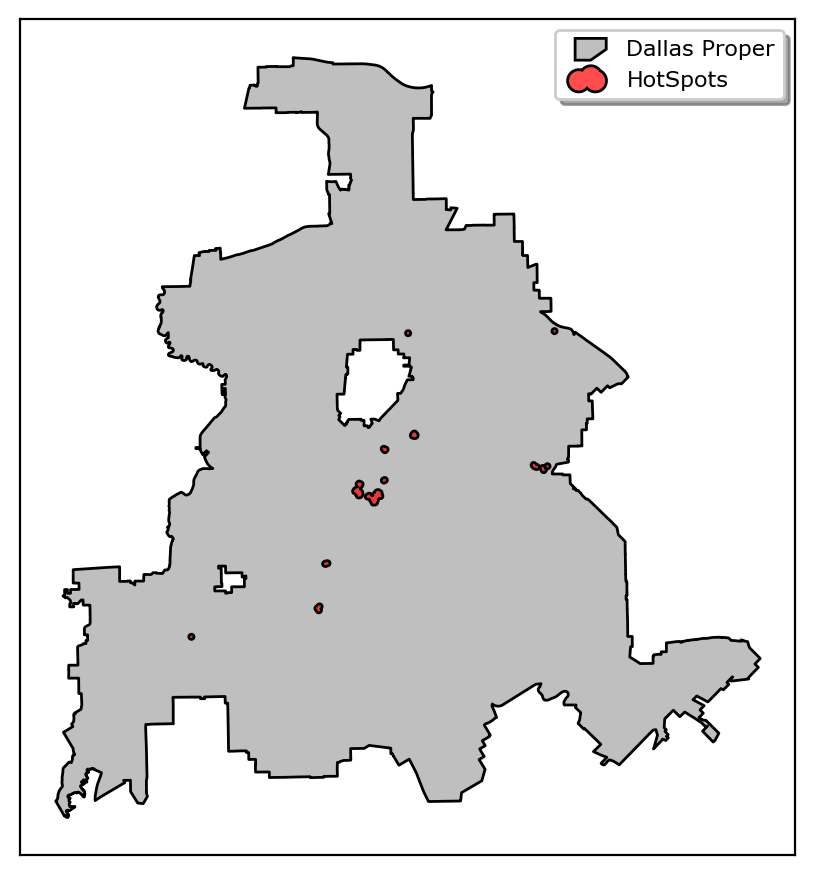

In [4]:
# Looking at the overall location of those hotspots
fig, ax = plt.subplots(figsize=(5,10))

# Doing the legend is painful, here are a few helper functions
# to take care of all the glyph creation
hm = {}
bn, bh = geo.geo_map(outline,ax,fill='grey',fill_alpha=0.5)
hn, hh = geo.geo_map(hs_mv,ax,fill='red',fill_alpha=0.7,leg_type='HotSpot')
hm[bn] = bh
hm[hn] = hh

ax.legend(hm.keys(),['Dallas Proper','HotSpots','Boundary2'],handler_map=hm, loc='upper right',fontsize=8)
xticks = ax.get_xaxis().set_ticks([])
yticks = ax.get_yaxis().set_ticks([])

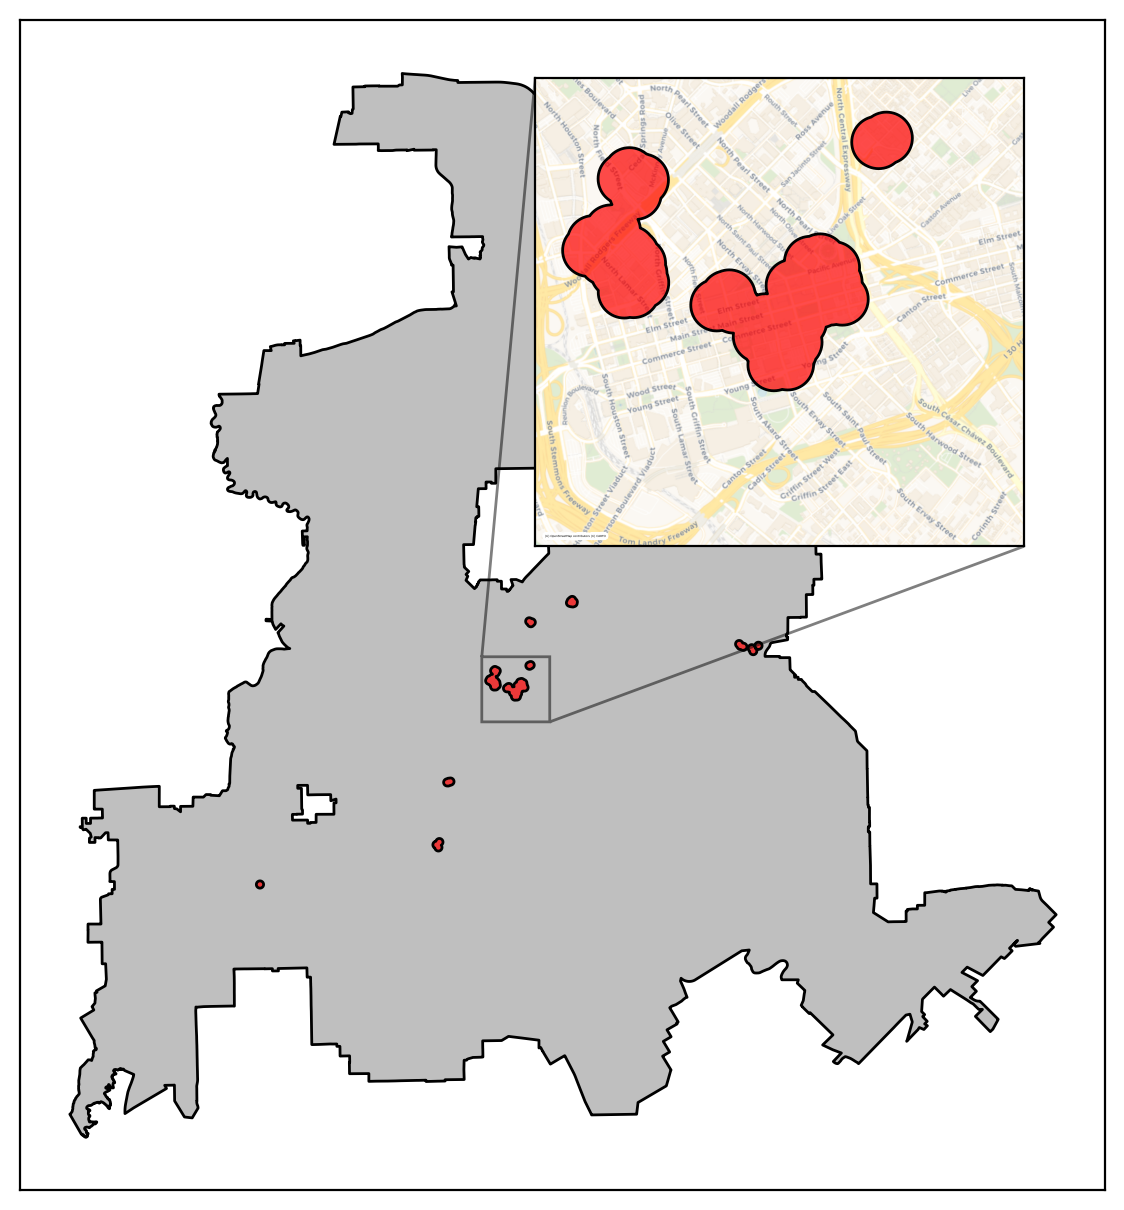

In [5]:
# Lets zoom in and draw a background map
biggest_hs = hs_mv.loc[0,'geometry'].buffer(3000).bounds
xlim = (biggest_hs[0],biggest_hs[2])
ylim = (biggest_hs[1],biggest_hs[3])

fig, ax = plt.subplots(figsize=(7,14))
bn, bh = geo.geo_map(outline,ax,fill='grey',fill_alpha=0.5)
hn, hh = geo.geo_map(hs_mv,ax,fill='red',fill_alpha=0.7,leg_type='HotSpot')
axins = ax.inset_axes([0.4, 0.55, 0.6, 0.4],xlim=xlim,ylim=ylim)
hn, hh = geo.geo_map(hs_mv,axins,fill='red',fill_alpha=0.7,leg_type='HotSpot')
cx.add_basemap(axins, crs=outline.crs.to_string(), 
               source=cx.providers.CartoDB.Voyager, zoom=15,
               attribution_size=1)
attribution_text = axins.texts[-1]
attribution_text.set_position((0.02, 0.02))
ax.indicate_inset_zoom(axins, edgecolor="black")
xticks = ax.get_xaxis().set_ticks([]), axins.get_xaxis().set_ticks([])
yticks = ax.get_yaxis().set_ticks([]), axins.get_yaxis().set_ticks([])


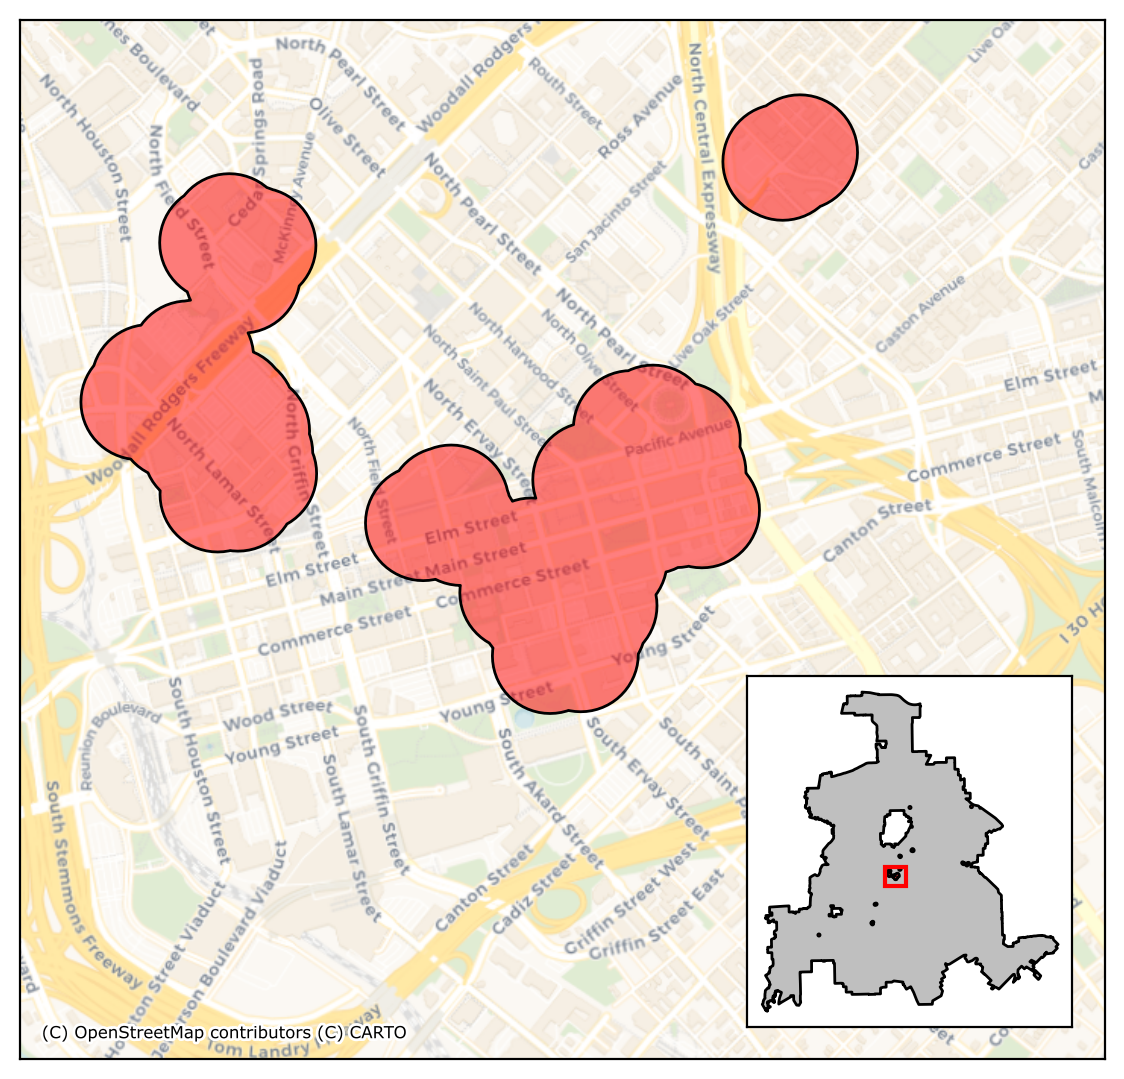

In [6]:
# It is easier to see reversing the zoom-in map
biggest_hs = hs_mv.loc[[0]].buffer(3000)
bh_bound = biggest_hs[0].bounds
xlim = (bh_bound[0],bh_bound[2])
ylim = (bh_bound[1],bh_bound[3])

fig, ax = plt.subplots(figsize=(7,7))
bn, bh = geo.geo_map(outline,ax,fill='none')
hn, hh = geo.geo_map(hs_mv,ax,fill='red',fill_alpha=0.5,leg_type='HotSpot')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
cx.add_basemap(ax, crs=outline.crs.to_string(), 
               source=cx.providers.CartoDB.Voyager, zoom=15,
               attribution_size=6)
attribution_text = ax.texts[-1]
attribution_text.set_position((0.02, 0.02))

# overview map
axins = ax.inset_axes([0.67, -0.1, 0.3, 0.6])
bn, bh = geo.geo_map(outline,axins,fill='grey',fill_alpha=0.5)
hn, hh = geo.geo_map(hs_mv,axins,fill='red',fill_alpha=0.7,leg_type='HotSpot')
rect = patches.Rectangle((xlim[0],ylim[0]), xlim[1]-xlim[0], ylim[1]-ylim[0],
                         linewidth=1.5, edgecolor='red', facecolor='none')
axins.add_patch(rect)

xticks = ax.get_xaxis().set_ticks([]), axins.get_xaxis().set_ticks([])
yticks = ax.get_yaxis().set_ticks([]), axins.get_yaxis().set_ticks([])

In [7]:
# You can create hotspots of multiple crimes, the resulting hotspot will have the info in them
rob_df = df[df['NIBR_DESC'] == 'ROBBERY'].copy()
ld = pd.get_dummies(rob_df['LOC_DESC']) # lists the different location types
rob_df[list(ld)] = ld

distance = 1000 # in feet
min_samp = 30

hs_rob = geo.db_hotspots(rob_df,distance,min_samp,sf=list(ld))
hs_rob.head(3)

,lab,geometry,weight,Apartment/Residence,Bar/Restaurant,Commercial,Gas/Convenience,Hotel/Motel,Other,Outdoor,Parking Lot,School,Store,Street
0,1,"POLYGON ((2468413.708 6997079.494, 2468347.804...",332,77,8,10,22,0,5,17,125,0,30,38
1,2,"POLYGON ((2489083.134 6969719.59, 2488990.735 ...",251,15,26,4,27,1,3,42,35,0,8,90
2,3,"POLYGON ((2483389.67 6948256.607, 2483292.597 ...",80,1,5,8,24,1,2,7,10,0,17,5


In [ ]:
# You can use weights, like crime harm weights or cost of crime weights, to create hotspots

# Approximate cost of crime estimates
dallas_cost = {'LARCENY/ THEFT OFFENSES': 1000, 
               'MOTOR VEHICLE THEFT': 800, 
               'DESTRUCTION/ DAMAGE/ VANDALISM OF PROPERTY': 500, 
               'ASSAULT OFFENSES': 2000, 
               'DRUG/ NARCOTIC VIOLATIONS': 500, 
               'BURGLARY/ BREAKING & ENTERING': 1200, 
               'ALL OTHER OFFENSES': 100, 
               'TRAFFIC VIOLATION - HAZARDOUS': 100, 
               'ROBBERY': 2500, 
               'PUBLIC INTOXICATION': 200, 
               'WEAPON LAW VIOLATIONS': 1000, 
               'FRAUD OFFENSES': 500, 
               'DRIVING UNDER THE INFLUENCE': 500, 
               'TRESPASS OF REAL PROPERTY': 100, 
               'FAMILY OFFENSES, NONVIOLENT': 500, 
               'STOLEN PROPERTY OFFENSES': 1000, 
               'EMBEZZELMENT': 500, 
               'COUNTERFEITING / FORGERY': 500}

df['CostCrime'] = df['NIBR_DESC'].replace(dallas_cost)
ct = pd.get_dummies(df['NIBR_DESC'])
df[list(ct)] = ct

# min sample has to be for the weights, so here $700,000
# takes around 9 seconds on my machine with the larger data
cost_hs = geo.db_hotspots(df,500,700_000,sf=list(ct),weight='CostCrime')
cost_hs


C:\Users\andre\AppData\Local\Temp\ipykernel_8440\1251360655.py:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CostCrime'] = df['NIBR_DESC'].replace(dallas_cost)


,lab,geometry,CostCrime,ALL OTHER OFFENSES,ASSAULT OFFENSES,BURGLARY/ BREAKING & ENTERING,COUNTERFEITING / FORGERY,DESTRUCTION/ DAMAGE/ VANDALISM OF PROPERTY,DRIVING UNDER THE INFLUENCE,DRUG/ NARCOTIC VIOLATIONS,...,"FAMILY OFFENSES, NONVIOLENT",FRAUD OFFENSES,LARCENY/ THEFT OFFENSES,MOTOR VEHICLE THEFT,PUBLIC INTOXICATION,ROBBERY,STOLEN PROPERTY OFFENSES,TRAFFIC VIOLATION - HAZARDOUS,TRESPASS OF REAL PROPERTY,WEAPON LAW VIOLATIONS
0,1,"POLYGON ((2490561.249 6970545.607, 2490515.05 ...",2613800,130,304,116,0,277,17,82,...,0,92,761,842,176,51,2,41,52,6
1,2,"POLYGON ((2498799.751 7002760.208, 2498755.394...",2040700,48,31,6,1,71,1,37,...,2,41,1307,635,11,19,5,84,6,1
2,3,"POLYGON ((2495672.551 6971762.583, 2495624.014...",1911800,154,204,41,1,182,50,207,...,1,43,553,452,267,53,12,108,9,72
3,4,"POLYGON ((2492395.574 6965734.798, 2492347.037...",1340000,384,75,14,14,53,11,1188,...,57,61,225,177,21,19,4,36,39,8
4,5,"POLYGON ((2490120.115 6971457.457, 2490108.192...",994400,102,96,17,1,73,3,155,...,2,28,280,308,81,30,2,16,11,18
5,6,"POLYGON ((2483762.86 7024920.139, 2483723.449 ...",973000,31,35,17,1,46,2,13,...,2,24,605,229,3,14,0,59,3,2
6,7,"POLYGON ((2475943.486 6993661.709, 2475904.075...",730900,59,15,2,2,26,3,161,...,2,45,197,164,94,1,1,8,13,220
7,8,"POLYGON ((2494313.959 6979985.355, 2494281.008...",720300,17,22,14,1,47,5,13,...,2,5,434,201,4,7,2,19,3,3


In [9]:
# Lets make an interactive map of these hotspots to view
basemap = geo.base_folium(boundary=outline,
                          legend_name="Dallas Proper")
geo.add_hotspots(basemap,cost_hs,["CostCrime"] + list(ct))
res = geo.save_map(basemap,file=None) # this is an optimized HTML object, also adds in legend
basemap